In [1]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import torch
import torch.optim as optim
from src.zig_model import ZIG

# 1) Load .env
load_dotenv()

# 2) Import your pipeline steps + the allen_api
from src.data_loader import allen_api
from src.pipeline_steps import (
    AnalysisPipeline,
    AllenStimuliFetchStep,
    ImageToEmbeddingStep,
    StimulusGroupKFoldSplitterStep,
    MergeEmbeddingsStep
)
from transformers import ViTModel, ViTImageProcessor

def make_container_dict(boc):
    experiment_container = boc.get_experiment_containers()
    container_ids = [dct['id'] for dct in experiment_container]
    eids = boc.get_ophys_experiments(experiment_container_ids=container_ids)
    df = pd.DataFrame(eids)
    reduced_df = df[['id', 'experiment_container_id', 'session_type']]
    grouped_df = reduced_df.groupby(['experiment_container_id', 'session_type'])[
        'id'].agg(list).reset_index()
    eid_dict = {}
    for row in grouped_df.itertuples(index=False):
        c_id, sess_type, ids = row
        if c_id not in eid_dict:
            eid_dict[c_id] = {}
        eid_dict[c_id][sess_type] = ids[0]
    return eid_dict

def main():
    # A) Allen BOC
    boc = allen_api.get_boc()

    # B) Container dict
    eid_dict = make_container_dict(boc)
    print(len(eid_dict), "containers found.")

    # C) Session->stimuli mapping
    stimulus_session_dict = {
        'three_session_A': ['natural_movie_one', 'natural_movie_three'],
        'three_session_B': ['natural_movie_one', 'natural_scenes'],
        'three_session_C': ['natural_movie_one', 'natural_movie_two'],
        'three_session_C2': ['natural_movie_one', 'natural_movie_two']
    }

    # D) HF model + processor
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    # E) Embedding cache dir
    embedding_cache_dir = os.environ.get('TRANSF_EMBEDDING_PATH', 'embeddings_cache')

    # F) Build pipeline with all steps
    pipeline = AnalysisPipeline([
        AllenStimuliFetchStep(boc),
        ImageToEmbeddingStep(processor, model, embedding_cache_dir),
        StimulusGroupKFoldSplitterStep(boc, eid_dict, stimulus_session_dict, n_splits=10),
        MergeEmbeddingsStep(),  # merges the neural folds with the image embeddings
    ])

    # G) Run pipeline on a single container/session/stimulus
    container_id = 511498742
    #session = 'three_session_A'
    #stimulus = 'natural_movie_three'
    session='three_session_B'
    stimulus='natural_scenes'
    result = pipeline.run((container_id, session, stimulus))

    # H) Print final results
    print("\n=== FINAL PIPELINE OUTPUT ===")
    print("Keys in 'result':", list(result.keys()))
    #  'raw_data_dct', 'embedding_file', 'folds', 'merged_folds', etc.

    print(f"Embedding file path: {result['embedding_file']}")
    folds = result['folds']
    print(f"Number of folds: {len(folds)}")

    merged_folds = result['merged_folds']
    for i, fold_data in enumerate(merged_folds, start=1):
        (Xn_train, Xe_train, Xn_test, Xe_test, frames_train, frames_test) = fold_data
        print(f"\nFold {i}:")
        print(f"  Xn_train: {Xn_train.shape}, Xe_train: {Xe_train.shape}")
        print(f"  Xn_test : {Xn_test.shape},  Xe_test : {Xe_test.shape}")
        print(f"  frames_train: {frames_train.shape}, frames_test: {frames_test.shape}")

    return merged_folds

/home/maria/MouseViT/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
merged_folds = main()

540 containers found.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BOOM /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
Found existing embeddings for model google_vit-base-patch16-224. Using file:
 /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
      frame  start    end
0        41  16101  16108
1        64  16109  16116
2        91  16116  16123
3        17  16124  16131
4        99  16131  16138
...     ...    ...    ...
5945     23  96067  96074
5946     91  96074  96081
5947     10  96082  96089
5948     78  96089  96096
5949     31  96097  96104

[5950 rows x 3 columns]
(5900, 171)

=== FINAL PIPELINE OUTPUT ===
Keys in 'result': ['container_id', 'session', 'stimulus', 'raw_data_dct', 'embedding_file', 'folds', 'merged_folds']
Embedding file path: /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
Number of folds: 10

Fold 1:
  Xn_train: (5300, 171), Xe_train: (5300, 768)
  Xn_test : (600, 17

In [9]:
def evaluate_model_on_fold(merged_folds, fold, model_path="/home/maria/MouseViT/trained_models/zig_model_fold.pth", save_path=None):
    """
    Evaluates the trained ZIG model on a specific test fold and computes the likelihood of the observed data 
    under the model.

    Args:
        merged_folds (list): List of folds containing (Xn_train, Xe_train, Xn_test, Xe_test, frames_train, frames_test).
        fold (int): The fold number to evaluate.
        model_path (str): Path to the trained model checkpoint.
        save_path (str, optional): If provided, saves the test probabilities as a .npy file.

    Returns:
        test_likelihoods (numpy.ndarray): A 2D NumPy array (num_neurons, num_time_points) containing the likelihood of each test data point.
    """

    # Load the trained model
    checkpoint = torch.load(model_path, map_location="cpu")  # Load model to CPU
    Xn_train, Xe_train, _, _, _, _ = merged_folds[fold]
    
    yDim = Xn_train.shape[1]  # Number of neurons (output dimension)
    xDim = Xe_train.shape[1]  # Input dimension (ViT embeddings)
    
    # Initialize model and load weights
    gen_nodes = 128  # Keep this consistent with training
    factor = np.min(Xn_train, axis=0) 
    model = ZIG(yDim, xDim, gen_nodes, factor)
    model.load_state_dict(checkpoint)
    model.eval()  # Set model to evaluation mode

    # Select the fold's test data
    _, _, Xn_test, Xe_test, _, _ = merged_folds[fold]

    # Convert test data to PyTorch tensors
    Xn_test_tensor = torch.tensor(Xn_test, dtype=torch.float32)
    Xe_test_tensor = torch.tensor(Xe_test, dtype=torch.float32)

    # Forward pass (no gradients needed since we are evaluating)
    with torch.no_grad():
        theta, k, p, loc, rate = model(Xe_test_tensor)  # Get model outputs

    # Compute probability of the observed data (Xn_test) under the ZIG model
    eps = 1e-6  # Small value for numerical stability
    mask = (Xn_test_tensor != 0)  # Identify nonzero spikes
    mask2 = (Xn_test_tensor == 0)
    print(mask)
    # Compute the probability of observed spike counts using the ZIG model:
    p_zeros = 1 - p  # Probability of being in the zero-inflated state
    p_spike = p * torch.exp(-k * torch.log(theta) - (Xn_test_tensor - loc) / theta) * \
              torch.exp((k - 1) * torch.log(torch.clamp(Xn_test_tensor - loc, min=eps)) - torch.lgamma(k))

    # Use mask to apply zero-inflation correctly:
    test_likelihoods = torch.where(mask, p_spike, p_zeros + eps).cpu().numpy()
    event_likelihoods= torch.where(mask, p, 0).cpu().numpy()
    event_likelihoods2= torch.where(mask2, p, 0).cpu().numpy()
    # Save as a .npy file if a save path is provided
    if save_path:
        np.save(save_path, test_likelihoods)
        print(f"Saved test likelihoods to {save_path}")

    print(f"Evaluated fold {fold}. Test likelihoods array shape: {test_likelihoods.shape}")

    return test_likelihoods, event_likelihoods, event_likelihoods2  # Return full 2D array (num_neurons, num_time_points)

In [10]:
test_likelihoods, event_likelihoods, event_likelihoods2=evaluate_model_on_fold(merged_folds, fold=0, model_path="/home/maria/MouseViT/trained_models/zig_model_fold.pth", save_path=None)

tensor([[ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
Evaluated fold 0. Test likelihoods array shape: (600, 171)


In [12]:
a=event_likelihoods2[event_likelihoods2>0]
b=event_likelihoods[event_likelihoods>0]
print(np.mean(a), np.mean(b))

0.04566071 0.05910847


(array([ 11.,  32.,  42.,  50.,  86., 109.,  58., 174.,  85.,  91., 154.,
        295.,  69., 195.,  99., 187., 194., 167., 128., 129., 132., 127.,
        141.,  86., 111.,  60.,  73.,  42.,  13., 240.,  32.,  53., 119.,
         70., 120.,   5., 190.,  27.,  40.,   5.,   0.,  35.,  19.,   0.,
          0.,  96.,  62.,  67.,  56.,   0.,   0.,  52.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  84.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  91.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  17.,  70.,   0.,   0.,   0.,
         90.]),
 array([0.01154671, 0.01339056, 0.01523441, 0.01707826, 0.01892211,
        0.02076596, 0.02260981, 0.02445365, 0.0262975 , 0.02814135,
        0.0299852 , 0.03182905, 0.0336729 , 0.03551675, 0.0373606 ,
        0.03920444, 0.04104829, 0.04289214, 0.04473599, 0.04657984,
        0.04842369, 0.05026754, 0.05211139, 0.

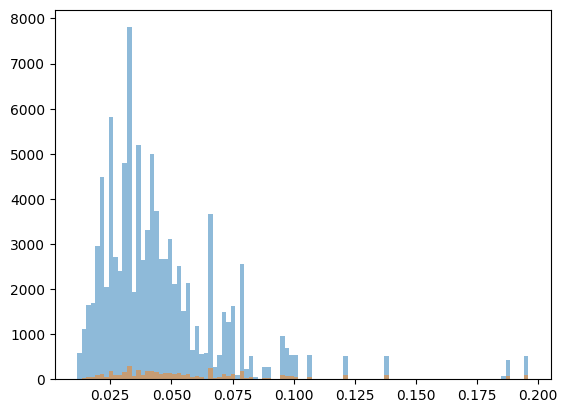

In [13]:
import matplotlib.pyplot as plt
plt.hist(a, bins=100, alpha=0.5, label='zero')
plt.hist(b, bins=100, alpha=0.5, label='spike')